<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This notebook is from Winter 2022. 
It uses the court data we scraped in October 2021 to defensively model a new mandatory minimum policy in VA.

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [3]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/110041657.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/110041657.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/110041657.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/110041657.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/110041657.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
/var/fold

In [4]:
sdc_data.head()

,Address,Amended Charge,Amended Charge Type,Amended Code Section,Arrest Date,Charge,Charge Type,Class,CodeSection,Commenced by,Concluded By,ConcurrentConsecutive,Costs,Court/DMV Surrender,DOB,Defendant,Disposition Date,Driver Improvement Clinic,Driving Restrictions,Filed,Fine Amount,Fines/Cost Paid,Jail/Penitentiary,Life/Death,Locality,Military,Offense Date,Operator License Suspension Time,Probation Starts,Probation Time,Probation Type,Program Type,Race,Restitution Amount,Restitution Paid,Sentence Suspended,Sentence Time,Sex,Traffic Fatality,VA Alcohol Safety Action,county,time_step,day,month,year,sentence_time,sentence_suspended,person_id,compartment_duration,CONSPIRACY,FIRST_DEGREE_MURDER,SECOND_DEGREE_MURDER,CAPITAL_MURDER,OTHER_MURDER,DRUG_POSSESSION,DRUG_SALE,DRUG_OTHER,ARSON,SEX_OFFENSE,DWI,WEAPON,BURGLARY,ROBBERY,LARCENY,ASSAULT,RAPE,KIDNAPPING,MANSLAUGHTER,crimes,CONSPIRACY_ANY,DRUG_POSSESSION_ANY,DRUG_SALE_ANY,DRUG_OTHER_ANY,KIDNAPPING_ANY,MANSLAUGHTER_ANY,LARCENY_ANY,WEAPON_ANY,ASSAULT_ANY,ROBBERY_ANY,BURGLARY_ANY,DWI_ANY,RAPE_ANY,SEX_OFFENSE_ANY,ARSON_ANY,FIRST_DEGREE_MURDER_ANY,SECOND_DEGREE_MURDER_ANY,OTHER_MURDER_ANY,CAPITAL_MURDER_ANY,total_sentence_months,crime_type
0,LYNCHBURG[.] VA 24506,NaN,NaN,NaN,NaN,RECKLESS DRIVING (SP 95/65 MR),Misdemeanor,NaN,46.2-862,General District Court Appeal,Trial - Judge With Witness,NaN,$88.00,License Was Not Surrendered,03/15/****,A GHAYYADA[.] AMER O,12/11/2002,NaN,Yes,10/15/2002,$500.00,Yes,Jail,NaN,COMMONWEALTH OF VA,NaN,08/23/2002,6 Month(s),NaN,NaN,NaN,NaN,White,NaN,NaN,0 Year(s)0 Month(s)90 Day(s),0 Year(s)0 Month(s)90 Day(s),Male,NaN,NaN,Louisa Circuit Court,-83.638356,11,12,2002,0 Year(s)0 Month(s)90 Day(s),0 Year(s)0 Month(s)90 Day(s),A GHAYYADA[.] AMER O03/15/****LYNCHBURG[.] VA ...,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,NaN
1,ROANOKE[.] VA 24017,NaN,NaN,NaN,12/05/2012,DRIVING WHILE INTOXICATED[.] 1ST,Misdemeanor,1,A.18.2-266,General District Court Appeal,Trial - Jury,NaN,$1473.00,License Was Not Surrendered,01/09/****,A'SIM[.] ZAHIR RAKIN; JR,02/17/2012,NaN,Yes,06/15/2011,$1250.00,NaN,Jail,NaN,COMMONWEALTH OF VA,NaN,11/20/2010,12 Month(s),NaN,NaN,NaN,NaN,Black,$0.00,NaN,NaN,7 Day(s),Male,No,Yes,Roanoke City Circuit Court,26.558904,17,2,2012,7 Day(s),0,A'SIM[.] ZAHIR RAKIN; JR01/09/****ROANOKE[.] V...,0.230137,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0.230137,DWI
2,WILLIAMSBURG[.] VA 23188,NaN,NaN,NaN,03/05/1997,IMPROPER DRIVING,M,O,46.2-869,General District Court Appeal,Trial - Judge With Witness,NaN,$71.00,NaN,11/03/****,AADAHL[.] CHRISTOPHER P.,06/24/1997,NaN,NaN,04/29/1997,$250.00,Yes,NaN,NaN,COMMONWEALTH OF VA,NaN,03/05/1997,NaN,NaN,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,Male,NaN,NaN,York County/Poquoson Circuit Court,-149.210959,24,6,1997,0,0,AADAHL[.] CHRISTOPHER P.11/03/****WILLIAMSBURG...,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,NaN
3,WOODBRIDGE[.] VA 22191,NaN,NaN,NaN,04/21/2015,AP-G POSSESSION OF MARIJUANA,Misdemeanor,U,18.2-250.1,General District Court Appeal,Trial - Judge With Witness,NaN,$477.50,License Was Not Surrendered,06/19/****,AAGESEN[.] KEVIN MICHAEL,10/01/2015,NaN,NaN,07/09/2015,$350.00,NaN,NaN,NaN,COMMONWEALTH OF VA,NaN,04/21/2015,6 Month(s),NaN,NaN,NaN,NaN,Asian Or Pacific Islander,$0.00,NaN,NaN,NaN,Male,No,NaN,Prince William Circuit Court,70.032877,1,10,2015,0,0,AAGESEN[.] KEVIN MICHAEL06/19/****WOODBRIDGE[....,0.000000,False,False,False,False,False,True,

In [5]:
sdc_data.groupby(['Charge Type', 'Class'], dropna=False).count().max(axis=1).unstack('Class')

Class,1,2,3,4,5,6,O,U,NaN
Charge Type,,,,,,,,,
Civil,2.0,NaN,NaN,NaN,NaN,NaN,NaN,276.0,202.0
F,321.0,2282.0,27.0,57.0,508.0,256.0,51950.0,1805.0,44407.0
Felony,4304.0,8874.0,12501.0,11826.0,104687.0,109797.0,9290.0,168696.0,168930.0
I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Infraction,13.0,4.0,3.0,1.0,NaN,NaN,NaN,10148.0,31892.0
M,15214.0,480.0,26.0,32.0,NaN,NaN,16670.0,793.0,54308.0
Misdemeanor,103867.0,4024.0,1354.0,2277.0,11.0,32.0,881.0,29320.0,98381.0
Other (Animal Violations[.] Bond Appeals),NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,423.0
NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,446.0


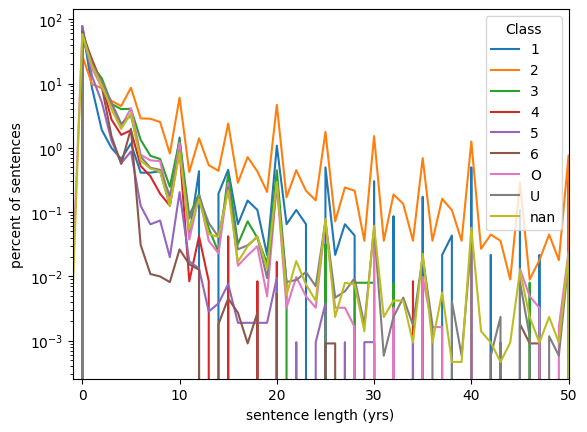

In [6]:
sdc_data['rounded_sentence_years'] = sdc_data.total_sentence_months.apply(lambda x: round(x / 12))
a = sdc_data[(sdc_data['Charge Type'] == 'F') | (sdc_data['Charge Type'] == 'Felony')].groupby(['Class', 'rounded_sentence_years'], dropna=False).count().max(axis=1).unstack('Class')
a = a.fillna(0)
a /= a.sum() / 100
a.plot(xlim=[-1,50], ylabel='percent of sentences', xlabel='sentence length (yrs)')
plt.yscale('log')

In [7]:
# average sentence in years
weighted = a.apply(lambda x: (x * a.index).sum() / x.sum(),axis=0)
weighted

Class
1      2.619676
2      7.920133
3      1.537516
4      0.876546
5      0.390770
6      0.584010
O      1.296604
U      1.310127
NaN    1.257039
dtype: float64

In [8]:
sdc_data['crime_level'] = 'other'
sdc_data.loc[((sdc_data['Charge Type'] == 'F') | (sdc_data['Charge Type'] == 'Felony')) & (sdc_data.Class == '1'),
             'crime_level'] = 'F1'


# Preprocessing

## TODOs
* maybe we shouldn't add the nulls back in indiscrimntly 


In [9]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching

sorted_data = sdc_data.copy()

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.total_sentence_months > 0.6]


# null_level_scale_factor = len(sorted_data) / len(sorted_data[sorted_data.Class.notnull()])
sorted_data = sorted_data[sorted_data.Class.notnull()]

scale_factor = len(sorted_data) / len(sorted_data[sorted_data.crime_type.notnull()])
sorted_data = sorted_data[sorted_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_level']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor #* null_level_scale_factor
outflows_data = outflows_data[(outflows_data['time_step'] > -108) & (outflows_data['time_step'] <= 33)]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

,time_step,crime_level,total_population,compartment,outflow_to
566,-107,F1,8.196925,pretrial,prison
567,-107,other,1176.258790,pretrial,prison
568,-106,F1,5.464617,pretrial,prison
569,-106,other,1045.107984,pretrial,prison
570,-105,F1,10.929234,pretrial,prison


In [10]:
scale_factor

1.3661542274238936

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/2040933619.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  outflows_data.groupby('time_step').sum().plot(ylim=[0,2500])


<AxesSubplot: xlabel='time_step'>

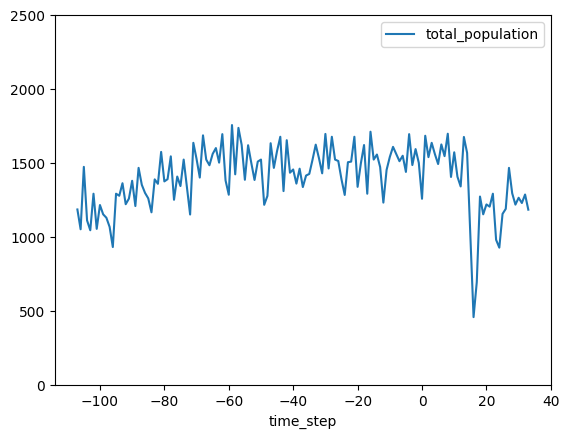

In [11]:
outflows_data.groupby('time_step').sum().plot(ylim=[0,2500])

In [12]:
# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data.loc[transitions_data.compartment_duration > 12 * 50, 'compartment_duration'] = 12 * 50
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_level'
]).count()[['Address']].reset_index().rename({'Address': 'total_population'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well


# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6 / 100,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6 / 100,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5 / 100,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4 / 100,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4/ 100
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

total_recidivism = recidivism_transitions.total_population.sum()

for crime_level in ['F1', 'other']:
    crime_recidivism = recidivism_transitions.copy()
    crime_recidivism = crime_recidivism.append({
        'compartment_duration': 36,
        'total_population': 1 - total_recidivism,
        'compartment': 'release',
        'outflow_to': 'release_full',
    }, ignore_index=True)
    crime_recidivism['crime_level'] = crime_level
    
    transitions_data = transitions_data.append(crime_recidivism)
    
    # adjust outflows so we're not double counting recidivism
    outflows_data.loc[
        outflows_data.crime_level == crime_level, 'total_population'
    ] /= 1 + total_recidivism


transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * 2,
    'total_population': [1] * 2,
    'compartment': ['release_full'] * 2,
    'outflow_to': ['release_full'] * 2,
    'crime_level': ['F1', 'other'],
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/530827072.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crime_recidivism = crime_recidivism.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/530827072.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_data = transitions_data.append(crime_recidivism)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/530827072.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crime_recidivism = crime_recidivism.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_18166/530827072.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

,compartment_duration,crime_level,total_population,compartment,outflow_to
0,1.0,F1,248.0,prison,release
1,1.0,other,28165.0,prison,release
2,2.0,F1,109.0,prison,release
3,2.0,other,15168.0,prison,release
4,3.0,F1,93.0,prison,release


In [13]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population *= len(sorted_data) / len(sdc_data)


total_population_data.total_population = total_population_data.total_population.astype(float)


In [14]:
len(sorted_data) / len(sdc_data)

0.2334585034826168

In [15]:
simulation_tag = "va_sb_79"

outflows_data = outflows_data[outflows_data.crime_level == 'F1'].rename({'crime_level': 'crime_type'}, axis=1)
transitions_data = transitions_data[transitions_data.crime_level == 'F1'].rename({'crime_level': 'crime_type'}, axis=1)

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
#     total_population_data,
    pd.DataFrame(),
    '../../state/VA/2022/policy_configurations/SB_79_model_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
1it [00:03,  3.10s/it]
1it [00:05,  5.74s/it]


# Modeling

In [15]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../../state/VA/2022/policy_configurations/SB_79_model_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/stanford-decarceration-collective-VLMPOYfe/lib/python3.8/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/pacopoler/.local/share/virtualenvs/stanford-decarceration-collective-VLMPOYfe/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1979: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(
/Users/pacopoler/.local/share/virtualenvs/stanford-d

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  11.460643768310547


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

simulation_time:  10.198225259780884


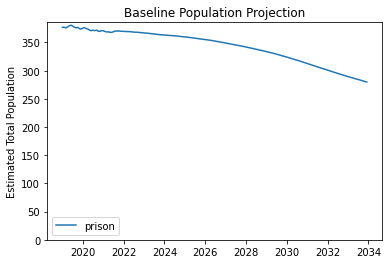

In [17]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'simulation_group: F1\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: other\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

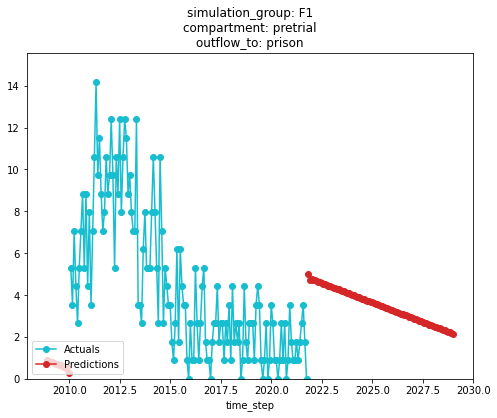

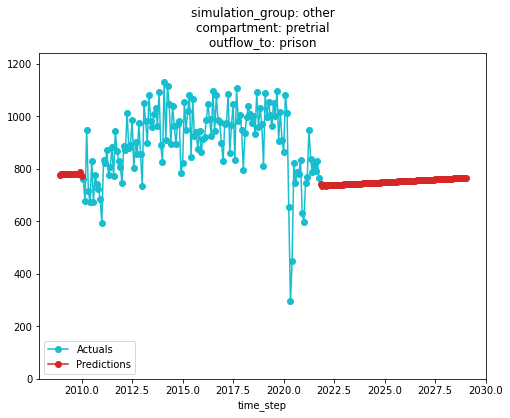

In [126]:
spark_sim.get_arima_output_plots('baseline_projections', by_simulation_group=True)

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation_factory.py:160: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for simulation_group_name, _ in transitions_data.groupby(disaggregation_axes):
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

initialization time:  8.643982172012329


/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default val

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

initialization time:  7.951884031295776


/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

simulation_time:  11.178955078125


/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../fu

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarni

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:188: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts_population_data.groupby(population_df_sort_indices)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: 

/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/pacopoler/Desktop/SDC/stanford-decarceration-collective/notebooks/../po

simulation_time:  10.568245887756348
518.65554283684


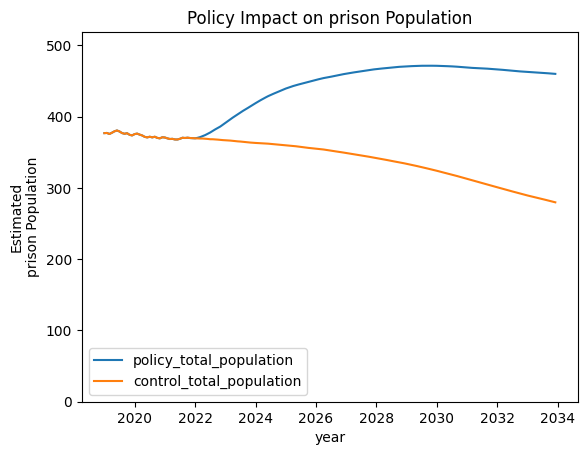

In [16]:
life_sentence_transitions = pd.DataFrame({
    'compartment_duration': [12 * 50],
    'total_population': [1],
    'compartment': ['prison'],
    'outflow_to': ['release'],
})


def apply_mm():
    return partial(TransitionTable.use_alternate_transitions_data, 
                   alternate_historical_transitions = life_sentence_transitions,
                   retroactive=False)

policy_list = [SparkPolicy(policy_fn=apply_mm(),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': 'F1'},
                                           policy_ts=36,
                                           apply_retroactive=False)]



test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [154]:
simulation_tag = 'va_sb_79'
results = spark_sim.upload_polxicy_simulation_results_to_bq(simulation_tag)

In [18]:
results = pd.DataFrame()
policy = spark_sim.simulator.pop_simulations['policy'].population_projections
control = spark_sim.simulator.pop_simulations['control'].population_projections
results['policy'] = policy[(policy.compartment == 'prison') & (policy.time_step >= 36)].total_population
results['control'] = control[(control.compartment == 'prison') & (control.time_step >= 36)].total_population

In [19]:
results

,policy,control
36,369.634558,369.634558
37,370.335024,369.515695
38,371.318989,369.325017
39,372.788934,369.323776
40,374.146946,369.091614
41,375.987108,368.767823
42,377.815114,368.358052
43,380.066450,368.319898
44,382.184360,368.117576
45,384.191338,367.794726


In [151]:
520.9-338.44

182.45999999999998